In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import scipy as sp 
from sklearn.decomposition import PCA

%matplotlib inline

E:\ANACONDA64\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Import stock and factor data
stock_data = pd.read_excel('Combined data.xlsx')
FF3D_data = pd.read_csv('FF3FactorD.csv')
MOM_data = pd.read_csv('MOMD.csv')

# Define Global Variables and Functions

### Global variables

In [3]:
start_date = '2019-05-28'
end_date = '2024-03-28'

rolling_window_size = 21

FF_factors = ['Mkt-RF', 'SMB', 'HML']
C_factors = ['Mkt-RF', 'SMB', 'HML', 'Mom']
CAPM_factor = ['Mkt-RF']

stock_list = stock_data['Ticker'].drop_duplicates().to_list()

### Regression wrapper & static and rolling regression for factor loading 

In [4]:
def linreg(y,x):
    # Custom function to wrap OLS for fitting
    reg = sm.OLS(y,x).fit(cov_type='HC2')
    return reg

In [5]:
def run_factor_model(data, stock_list, factors):
    """
    Fit any factor model to each stock in the list and store results, including residuals.

    Parameters:
    - data (pd.DataFrame): Contains stock returns and factor returns.
    - stock_list (list): Stocks to be analyzed.
    - factors (list): Names of factors in the data, including the market factor for CAPM, etc.

    Returns:
    - results (pd.DataFrame): Alpha and betas for each stock.
    - residuals (pd.DataFrame): Residuals for each stock.
    """
    # Prepare DataFrame to store coefficients and residuals
    results = pd.DataFrame(index=stock_list, columns=['alpha'] + factors)
    residuals = pd.DataFrame(index=data.index)

    # ****** this is defined in Quantopian lec but not needed. 
    F = data[factors]
    #*******
    
    # Loop through each stock to perform regression
    for stock in stock_list:
        print(f'Fitting model for {stock}')
        y = data[stock]
        x = sm.add_constant(data[factors])
        
        model = linreg(y, x)
        print(model.summary())
        
        # Store regression coefficients
        results.loc[stock, 'alpha'] = model.params['const']
        for factor in factors:
            results.loc[stock, factor] = model.params[factor]
            
#         # Create factor exposure matrix (B) for risk decomp  
            B = results[factors]
    
#         factor_col = results.columns.tolist()[1:]
#         print(factor_col)
#         B = results[factor_col]
        
        
        # Store residuals
        residuals[stock] = model.resid
        
    return F,B, results, residuals

In [6]:
def run_rolling_regression(data, stock_list, factors, rolling_window_size):
    """
    Run rolling regression for given stocks and factors, and plot coefficients over time using dates on the x-axis.

    Parameters:
        data (DataFrame): The data containing stock returns and factor values, indexed by date.
        stock_list (list): List of stock symbols to run the regression for.
        factors (list): List of factor column names in the data.
        rolling_window_size (int): Number of observations in the rolling window.
    """
    coef_dfs = {}  # Dictionary to store coefficients DataFrame for each stock

    for stock in stock_list:
        print(f'Processing {stock}...')
        # Dict comprehension
        stock_coefs = {factor: [] for factor in ['alpha'] + factors}
        dates = []  # List to store the dates for plotting

        for k in range(len(data) - rolling_window_size):
            y = data[stock].iloc[k:rolling_window_size + k + 1]
            x = add_constant(data[factors].iloc[k:rolling_window_size + k + 1])
            temp_reg = sm.OLS(y, x).fit(cov_type='HC2')

            stock_coefs['alpha'].append(temp_reg.params['const'])
            for factor in factors:
                stock_coefs[factor].append(temp_reg.params[factor])
            dates.append(data.index[rolling_window_size + k])  # Append the last date of the window

        # Creating a DataFrame for the current stock, indexed by the corresponding dates
        coef_df = pd.DataFrame(stock_coefs, index=dates)
        coef_dfs[stock] = coef_df

        # Plot each coefficient in separate figures
        for coef in stock_coefs.keys():
            plt.figure(figsize=(10, 4))
            plt.plot(coef_df.index, coef_df[coef], label=f'{coef} for {stock}')
            plt.title(f'{coef.capitalize()} over Time for {stock}')
            plt.xlabel('Date')
            plt.ylabel(f'{coef.capitalize()} Value')
            plt.legend()
            plt.show()

    return coef_dfs

### Generating equity portfolio for given constituents and corresponding weights

In [7]:
# We assume a buy-and-hold strategy, meaning that when we only allocate the weight at inception, and will not rebalance
def generate_portfolio(sdata,stock_list,weights, initial_endow,start_date):
    
    """
    Generate a buy-and-hold portfolio with a set initial endowment consists of any given security with arbitrary weights 

    Parameters:-
        data (DataFrame): The data containing all stocks returns, indexed by date
        stock_list (list): The list of stocks to be included in the portfolio
        weights (list): List of weights matching the number of stocks
        initial_endow (int): Initial endowment to invest in the portfolio
        start_date (string in the format '%Y-%m-%d'): Portfolio inception date
    """
    
    weights = np.array(weights)
    
    if not np.isclose(weights.sum(),1):
        raise ValueError('Weights must sum up to 1')
        
    # Handle exceptions associated with incorrect # of assets and weights assigned 
    if len(stock_list) != len(weights):
        raise ValueError("The number of stocks in stock_list must be the same as the number of items in the weights list")        
    
        
    sdata.set_index('Date',inplace = True)
    sdata=sdata[stock_list]+1 # To obtain gross return
    sdata.loc[start_date]=weights*initial_endow
    port_data = sdata.cumprod()
    port_data['Portfolio_value'] = port_data.sum(axis=1) # sum horizontally (by rows)
    # Calculate portfolio return
    port_data['Portfolio_return'] = port_data['Portfolio_value'].pct_change()
    
    # Get portfolio mean
    port_mean_ret = port_data['Portfolio_return'].mean()
    
    # Get portfolio Cov matrix
    port_cov_matrix = data[stock_list][1:].cov()
    
    # Get portfolio st.d
    port_var = np.dot(weights.T,np.dot(port_cov_matrix,weights))
    port_std= np.sqrt(port_var)
    
    weight_data = pd.DataFrame(index=port_data.index)
    for stock in stock_list:
        weight_data[stock] = port_data[stock] / port_data['Portfolio_value']
    
    # Visualize
    plt.figure(figsize=(9,4))
    plt.plot(port_data['Portfolio_return'])
    plt.title('Daily Portfolio Return')
    plt.xlabel('Date')  
    plt.ylabel('Returns')
    
    plt.figure(figsize=(9,4))
    plt.plot(port_data['Portfolio_return'].cumsum())
    plt.title('Cumulative Portfolio Return')
    plt.xlabel('Date')  
    plt.ylabel('Cumulative Returns')
    
    
    plt.figure(figsize=(12, 8))  # Set the size of the plot

    # Plot each column
    for column in weight_data.columns:
        plt.plot(weight_data.index, weight_data[column], label=column, linewidth=2)

    plt.title('Stock Weight in Portfolio Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weight')
    plt.legend()

#     plt.grid(True) 
    plt.show()
    
    return port_data, weight_data, port_mean_ret, port_cov_matrix, port_std

### Risk decomposition in multi-factor framework

In [8]:
# Risk decomposition

# Spliting variance into common factor risks
# Based on entire period instead of rolling

"""
port_sigma**2 = w * B * V * B.T * w.T + w * D * w.T

where 
    B = matrix of factor exposures of n assets to the factor
    V = the covariance matrix of factors
    D = the specific variance
    w = weight of portfolio weights for n assets
    wBVBw = common factor variance
    wDw = specific variance
"""

def factor_risk_decomp(data, B, factors):
    # For a buy-and-hold portfolio weights changes so need to come up with assumption for
    # weights and factor exposure and variance estiamtion
    # Let n denote # of assets
    # Let k deonote # of factors
    
    """
    Decompose factor risk for a portfolio using average weights, factor loadings, and factor covariances.

    Parameters:
        weight_data (DataFrame): DataFrame containing daily weights of each asset.
        B (DataFrame): Beta matrix with factor loadings (n x k).
        factor_data (DataFrame): DataFrame with factor returns to compute covariance.

    Returns:
        W (np.array): Column vector of average weights (n x 1).
        V (np.array): Covariance matrix of factor returns (k x k).
        common_factor_variance (float): Calculated common factor variance.
    """
        
    # Set up
    
    # Taking average weights of the daily portfolio weight data
    
    W = np.asarray(weight_data.mean()).reshape(-1, 1) # Note this is (n x 1) matrix/ vector
    V = np.asarray(data[factors].cov()) # this is a (k x k)matrix
    B = np.asarray(B)
    if B.shape[1] != V.shape[0]:
        raise ValueError("Dimension mismatch: Number of factors in B must match dimension of V.")
        
#     common_factor_variance = W.T.dot(B.dot(V).dot(B.T)).dot(W)

    # Common variance
    # Access the only item stored in the array
    common_factor_variance = (W.T @ B @ V @ B.T @ W)[0,0]
    
    print(f"Common Factor Variance: {common_factor_variance:.6f}")
    
    # specific variance
    D = np.diag(np.asarray(residuals.var())) * residuals.shape[0] / (residuals.shape[0]-1)
    specific_variance = W.T.dot(D).dot(W)[0,0]
    
    print(f"Specific Variance: {specific_variance:.6f}")
    
    
    #  percentage of common factor risk
    common_factor_risk_pct = common_factor_variance/(common_factor_variance+specific_variance)
    print(f"Percentage of Portfolio Variance Due to Common Factor Risk: {common_factor_risk_pct:.2f}%")
    
    return common_factor_risk_pct, common_factor_variance, specific_variance

### Portfolio-level performance and risk metrics

In [9]:
# Assuming fixed rf for simplicity 
def get_Sharpe(rf = 0.0002): # 5.04% annualized RF rate 
    port_Sharpe_ratio = (port_mean_ret-rf)/port_std
    
    return port_Sharpe_ratio

In [10]:
# Get Sortino
def get_Sortino(port_data,freq=1 ): # Based on daily return serires
    port_data['Excess_return'] = port_data['Portfolio_return'] - data['RF']
    mean_excess_ret = port_data['Excess_return'].mean() * freq
    negative_ret = port_data[port_data['Excess_return'] < 0]['Excess_return']

    downside_deviation = negative_ret.std()*np.sqrt(freq)

    sortino = mean_excess_ret / downside_deviation
    
#     print(mean_excess_ret, downside_deviation, sortino)
    return downside_deviation, sortino


In [11]:
# Get MDD
def get_MDD(port_data):
    """
    Calculate the Maximum Drawdown (MDD) from a series of portfolio daily returns.

    Parameters:
        port_data (DataFrame): DataFrame containing the portfolio returns.

    Returns:
        float: The Maximum Drawdown value (relative to portfolio's peak value, expressed as a negative number (or zero if no drawdown).
    """
    comp_ret = (1 + port_data['Portfolio_return']).cumprod()
    peak = comp_ret.expanding(min_periods = 1).max()
    drawdown = (comp_ret / peak)-1
    MDD = drawdown.min()   
    
    # Find the date (index) of the maximum drawdown
    MDD_date = drawdown.idxmin()
    
    # Find the onset of the drawdown (last peak before MDD)
    MDD_start_date = peak.loc[:MDD_date][peak == peak.loc[:MDD_date].max()].idxmax()
    
    # Find the end of the drawdown (when returns recover to the peak at onset)
    recovery = comp_ret.loc[MDD_date:]
    end_date = recovery[recovery >= peak.loc[MDD_start_date]].idxmin() if not recovery[recovery >= peak.loc[MDD_start_date]].empty else np.nan


    return MDD, MDD_start_date, MDD_date, end_date, drawdown, comp_ret

def plot_drawdown(port_data):
    MDD, MDD_start_date, MDD_date, end_date, drawdown, comp_ret = get_MDD(port_data)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(comp_ret, label='Compounded Returns')
    plt.plot(drawdown, label='Drawdown', color='red')
    plt.scatter([MDD_start_date, MDD_date, end_date], [comp_ret.loc[MDD_start_date], comp_ret.loc[MDD_date], comp_ret.loc[end_date]], color='orange')
    plt.axvline(x=MDD_start_date, color='green', linestyle='--', label='Start of MDD')
    plt.axvline(x=MDD_date, color='red', linestyle='--', label='Bottom of MDD')
    if pd.notna(end_date):
        plt.axvline(x=end_date, color='blue', linestyle='--', label='End of MDD (Recovery)')
    plt.title('Portfolio Drawdown Analysis')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [12]:
# Get VaR
def get_VaRs(port_data, port_value, alpha = 0.05, horizon = 1):
    
    z_score = sp.stats.norm.ppf(1-alpha)
    
    # Get parametric VaR, assuming a non-zero mean normal distribution
    normal_parametric_VaR = (z_score*port_std - port_mean_ret)*np.sqrt(horizon)
    dollar_parametric_VaR = normal_parametric_VaR*port_value
    normal_parametric_CVaR =  (1/(1 - alpha))*sp.stats.norm.expect(lambda x: x, lb = normal_parametric_VaR)
#     normal_parametric_CVaR2 =  (1/alpha)*sp.stats.norm.expect(lambda x: x, lb = normal_parametric_VaR)
    
    # Get historical VaR     
    historical_VaR = port_data['Portfolio_return'].quantile(alpha)
    dollar_historical_VaR = historical_VaR * port_value
    historical_CVaR = port_data[port_data['Portfolio_return'] <= historical_VaR]['Portfolio_return'].mean()
    
    # Get incremental, individual, component, and marginal VaR
    
    # Get incremental, individual, component, and marginal VaR
    
    # Plot return distribution with VaR indication
    plt.figure(figsize=(10, 5))
    plt.hist(port_data['Portfolio_return'], bins=40, alpha=0.75, color='blue', label='Return Distribution')
    plt.axvline(x=historical_VaR, color='red', linestyle='--', label=f'Historical VaR ({alpha*100}%): {historical_VaR*100:.2f}%')
    plt.axvline(x=-normal_parametric_VaR, color='green', linestyle='--', label=f'Parametric VaR ({alpha*100}%): {-normal_parametric_VaR*100:.2f}%')
    plt.title('Portfolio Return Distribution with VaR')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
#     return dollar_parametric_VaR, normal_parametric_VaR, normal_parametric_CVaR, dollar_historical_VaR,historical_VaR, historical_CVaR
    
    return {
    'Dollar Parametric VaR': dollar_parametric_VaR,
    'Parametric VaR': normal_parametric_VaR,
    'Parametric CVaR': normal_parametric_CVaR,
    'Dollar Historical VaR': dollar_historical_VaR,
    'Historical VaR': historical_VaR,
    'Historical CVaR': historical_CVaR
}

In [13]:
# Get Calmar ratio
def get_Calmar(port_data, freq = 1):
    MDD, _, _, _, _, _= get_MDD(port_data)
    mean_ret = port_data['Portfolio_return'].mean()*freq
    Calmar = mean_ret/abs(MDD)
    
    return Calmar


# Data cleaning

In [14]:
# Remove the last 2 empty columns
FF3D_data.drop(FF3D_data.tail(2).index,inplace = True)
MOM_data.drop(MOM_data .tail(2).index,inplace = True)

# convert date to Pandas date format
FF3D_data['Date']= pd.to_datetime(FF3D_data['Date'],format = '%Y%m%d')
MOM_data['Date']= pd.to_datetime(MOM_data['Date'],format = '%Y%m%d')
stock_data['Date'] = pd.to_datetime(stock_data['Date'],format = '%Y%m%d')

# Set date as index 
FF3D_data.set_index('Date',inplace = True)
MOM_data.set_index('Date',inplace = True)
# stock_data.set_index('Date',inplace = True)

FF3D_data[FF_factors]=FF3D_data[FF_factors]/100
FF3D_data['RF']=FF3D_data['RF']/100
MOM_data['Mom'] =MOM_data['Mom']/100

# Slice dataframes to the last 5 year period ending in end_date
FF3D_data = FF3D_data[(FF3D_data.index>=start_date) &
              (FF3D_data.index<=end_date)]
MOM_data = MOM_data[(MOM_data.index>=start_date) &
              (MOM_data.index<=end_date)]
stock_data = stock_data[(stock_data['Date']>=start_date) &
              (stock_data['Date']<=end_date)]

In [15]:
# stock_list = stock_data['Ticker'].drop_duplicates().to_list()

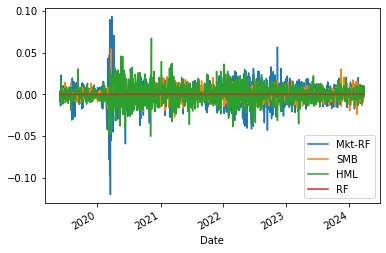

In [16]:
FF3D_data.plot();

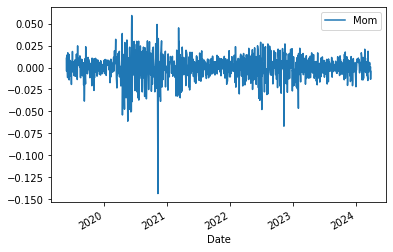

In [17]:
MOM_data.plot();

In [18]:
# Calculate return
# Use groupby function to make sure stock returns are recalculated for each new ticker i.e., not continuous after changing ticker
stock_ret = stock_data.groupby('Ticker')['Close'].apply(lambda x: x.pct_change(1))
stock_data['Return'] = stock_ret.droplevel(0)
stock_data

,Date,Close,Ticker,Return
0,2019-05-28,34.139999,WMT,NaN
1,2019-05-29,34.040001,WMT,-0.002929
2,2019-05-30,34.063332,WMT,0.000685
3,2019-05-31,33.813332,WMT,-0.007339
4,2019-06-03,33.986668,WMT,0.005126
...,...,...,...,...
12545,2024-03-22,172.279999,AAPL,0.005310
12546,2024-03-25,170.850006,AAPL,-0.008300
12547,2024-03-26,169.710007,AAPL,-0.006673
12548,2024-03-27,173.309998,AAPL,0.021213


In [20]:
stock_data

,Date,Close,Ticker,Return
0,2019-05-28,34.139999,WMT,NaN
1,2019-05-29,34.040001,WMT,-0.002929
2,2019-05-30,34.063332,WMT,0.000685
3,2019-05-31,33.813332,WMT,-0.007339
4,2019-06-03,33.986668,WMT,0.005126
...,...,...,...,...
12545,2024-03-22,172.279999,AAPL,0.005310
12546,2024-03-25,170.850006,AAPL,-0.008300
12547,2024-03-26,169.710007,AAPL,-0.006673
12548,2024-03-27,173.309998,AAPL,0.021213


In [21]:
stock_data_final = stock_data.pivot(columns='Ticker',values = 'Return',index='Date')
stock_data_final

Ticker,AAPL,AMZN,GE,GOOG,MA,META,MSFT,NVDA,TSLA,WMT
Date,,,,,,,,,,
2019-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-29,-0.004769,-0.009388,0.001068,-0.015598,0.000513,-0.011502,-0.009670,-0.020861,0.006147,-0.002929
2019-05-30,0.005187,-0.001578,0.010672,0.001335,0.002485,0.004501,0.006323,-0.008764,-0.008638,0.000685
2019-05-31,-0.018116,-0.022711,-0.003168,-0.012809,-0.010622,-0.030272,-0.016305,-0.026238,-0.016258,-0.007339
2019-06-03,-0.010110,-0.046409,0.009534,-0.061071,-0.036701,-0.075055,-0.031048,-0.012402,-0.033431,0.005126
...,...,...,...,...,...,...,...,...,...,...
2024-03-22,0.005310,0.004042,-0.008435,0.020371,-0.014264,0.003584,-0.001467,0.031213,-0.011515,-0.009439
2024-03-25,-0.008300,0.004696,-0.009478,-0.004085,-0.011689,-0.012873,-0.013715,0.007562,0.010537,-0.004929
2024-03-26,-0.006673,-0.007846,0.000346,0.003639,0.001596,-0.014174,-0.002861,-0.025694,0.029195,-0.000991


# EDA

<Axes: xlabel='Ticker'>

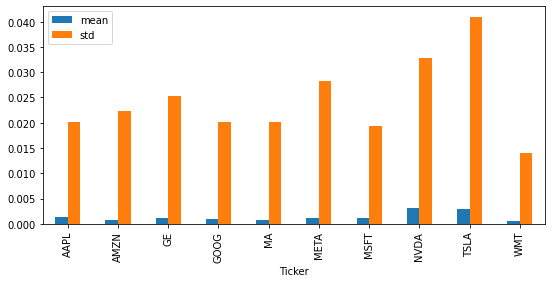

In [22]:
# Print summary stats for the stocks & factor data
stock_stat = stock_data_final.describe(percentiles=[.1,.25,.5,.75,.9,.95])
FF3D_stat =FF3D_data.describe(percentiles=[.1,.25,.5,.75,.9,.95])
MOM_stat =MOM_data.describe(percentiles=[.1,.25,.5,.75,.9,.95])


stock_stat.loc[['mean', 'std']].T.plot.bar(figsize= (9,4))
# High return and std for TSLA and low std for WMT, consistent with our expectation

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5')])

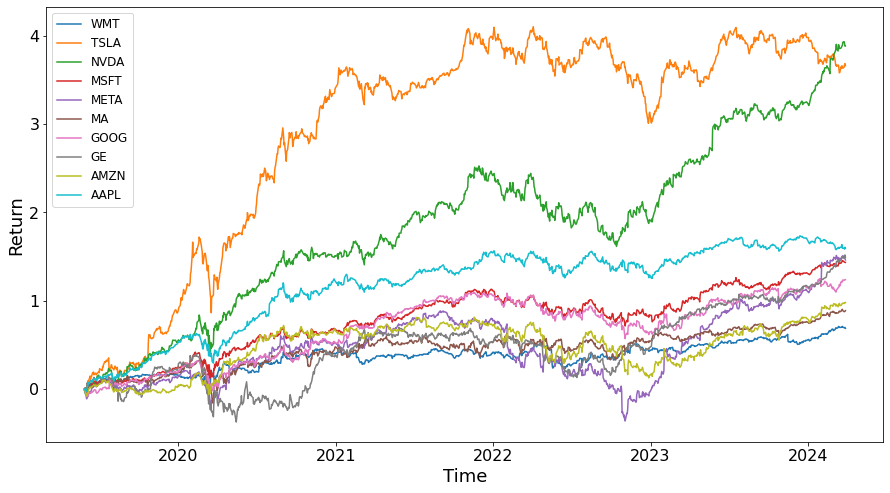

In [23]:
plt.figure(figsize=(15,8))

for stock in stock_list:
    plt.plot(stock_data[stock_data.Ticker==stock]['Date'],
            stock_data[stock_data.Ticker==stock]['Return'].cumsum(),label = stock)
    
plt.xlabel('Time', fontsize=18)
plt.ylabel('Return', fontsize=18)
plt.legend(loc='best',fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Static Security Factor Loading 

In [24]:
stock_data_final.reset_index(inplace = True)
FF3D_data.reset_index(inplace= True)
MOM_data.reset_index(inplace=True)

# Merge data to perform regression and the data will contain ALL factor data, which will
# be used subsequently throughout this project
data = stock_data_final.merge(
    FF3D_data[['Date','Mkt-RF','SMB','RF','HML']],on= 'Date',how = 'left')
data = data.merge(
    MOM_data[['Date','Mom']],on = 'Date',how= 'left')

data.dropna(inplace=True)
data.set_index('Date',inplace= True)
# data

In [25]:
for stock in stock_list:
    data[stock] = data[stock]- data['RF']
# data

In [26]:
# FF 3 factor model result 
F, B, results, residuals = run_factor_model(data, stock_list, FF_factors)

Fitting model for WMT
                            OLS Regression Results                            
Dep. Variable:                    WMT   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     37.85
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           2.19e-23
Time:                        12:48:25   Log-Likelihood:                 3629.6
No. Observations:                1218   AIC:                            -7251.
Df Residuals:                    1214   BIC:                            -7231.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.0

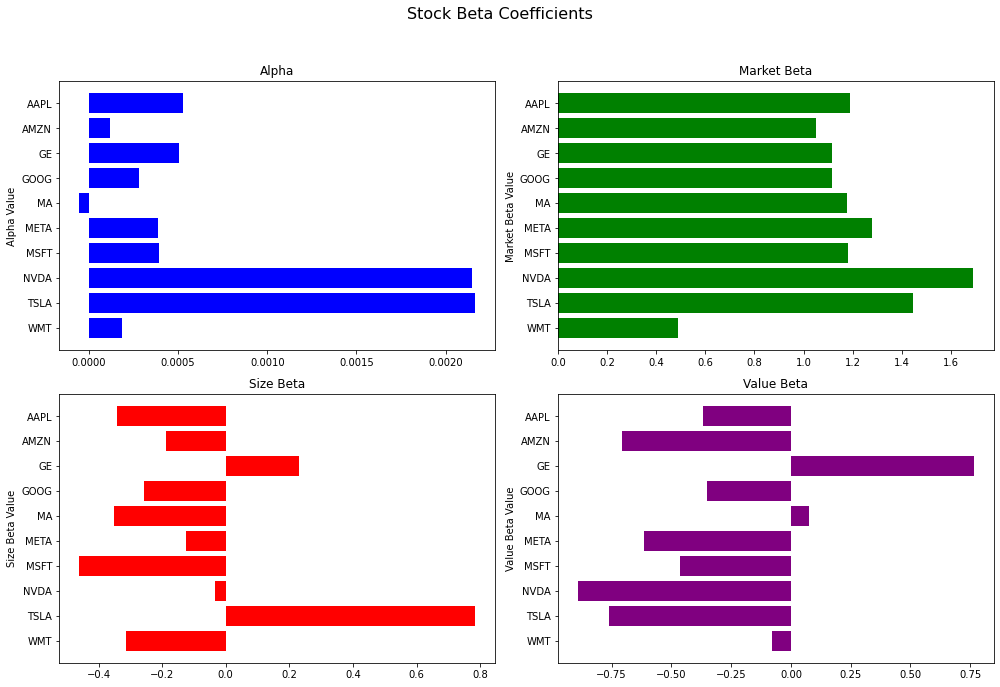

In [27]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Stock Beta Coefficients', fontsize=16)

# Alpha
axes[0, 0].barh(results.index, results['alpha'], color='blue')
axes[0, 0].set_title('Alpha')
axes[0, 0].set_ylabel('Alpha Value')

# Market Beta
axes[0, 1].barh(results.index, results['Mkt-RF'], color='green')
axes[0, 1].set_title('Market Beta')
axes[0, 1].set_ylabel('Market Beta Value')

# Size Beta
axes[1, 0].barh(results.index, results['SMB'], color='red')
axes[1, 0].set_title('Size Beta')
axes[1, 0].set_ylabel('Size Beta Value')

# Value Beta
axes[1, 1].barh(results.index, results['HML'], color='purple')
axes[1, 1].set_title('Value Beta')
axes[1, 1].set_ylabel('Value Beta Value')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [28]:
# C 4 factor model result 
F_C, B_C, C_results, residuals_C = run_factor_model(data, stock_list, C_factors)


Fitting model for WMT
                            OLS Regression Results                            
Dep. Variable:                    WMT   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     29.16
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           3.56e-23
Time:                        12:48:26   Log-Likelihood:                 3636.0
No. Observations:                1218   AIC:                            -7262.
Df Residuals:                    1213   BIC:                            -7236.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.0

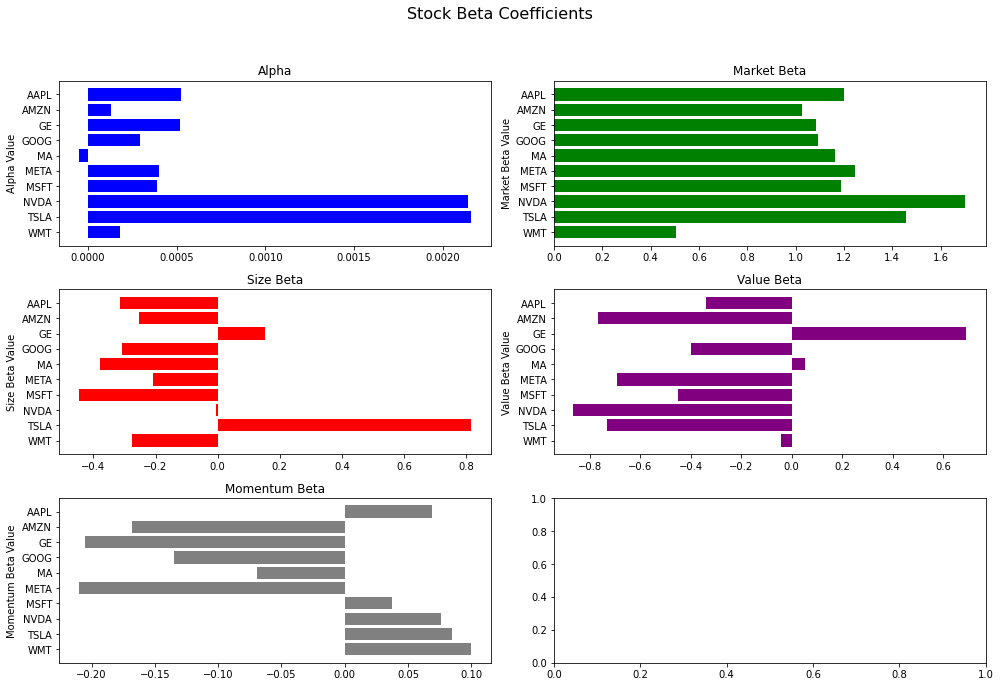

In [29]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.suptitle('Stock Beta Coefficients', fontsize=16)

# Alpha
axes[0, 0].barh(C_results.index, C_results['alpha'], color='blue')
axes[0, 0].set_title('Alpha')
axes[0, 0].set_ylabel('Alpha Value')

# Market Beta
axes[0, 1].barh(C_results.index, C_results['Mkt-RF'], color='green')
axes[0, 1].set_title('Market Beta')
axes[0, 1].set_ylabel('Market Beta Value')

# Size Beta
axes[1, 0].barh(C_results.index, C_results['SMB'], color='red')
axes[1, 0].set_title('Size Beta')
axes[1, 0].set_ylabel('Size Beta Value')

# Value Beta
axes[1, 1].barh(C_results.index, C_results['HML'], color='purple')
axes[1, 1].set_title('Value Beta')
axes[1, 1].set_ylabel('Value Beta Value')

# Momentum Beta
axes[2, 0].barh(C_results.index, C_results['Mom'], color='gray')
axes[2, 0].set_title('Momentum Beta')
axes[2, 0].set_ylabel('Momentum Beta Value')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Rolling Security Beta Loading

Processing WMT...


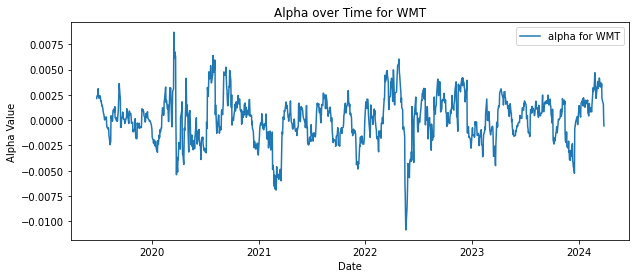

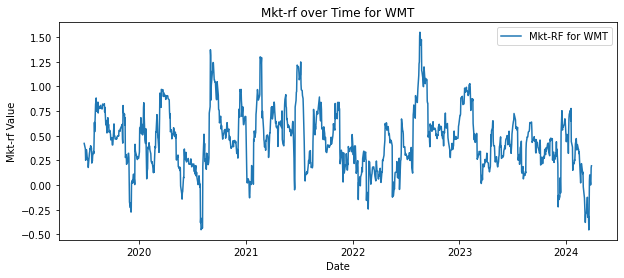

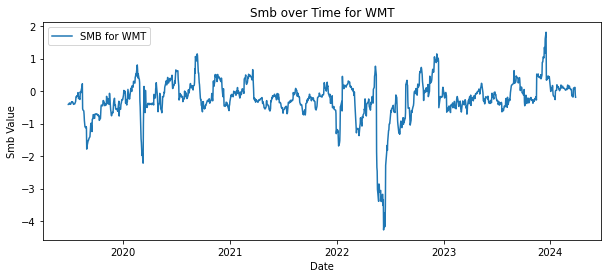

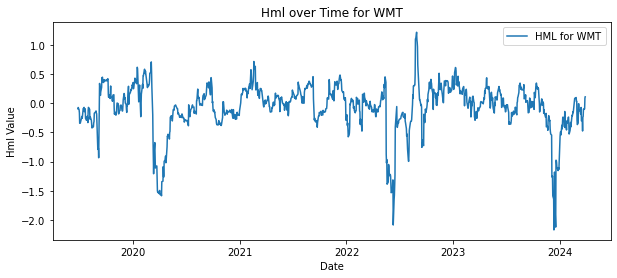

Processing TSLA...


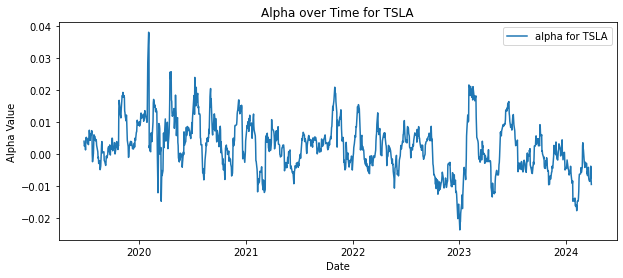

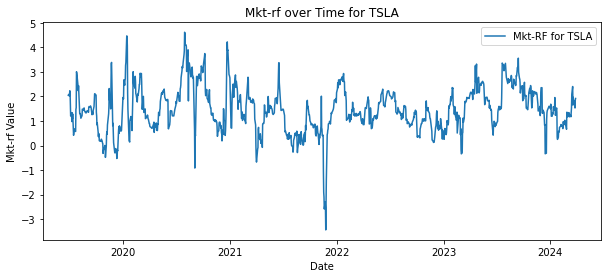

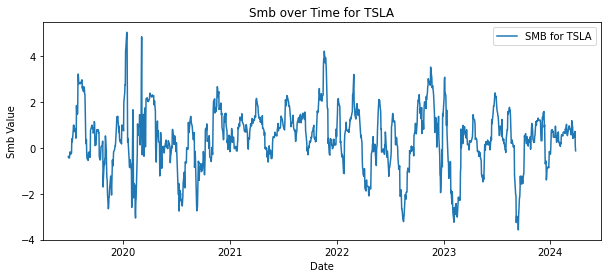

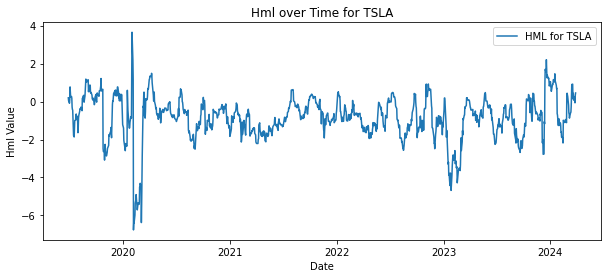

Processing NVDA...


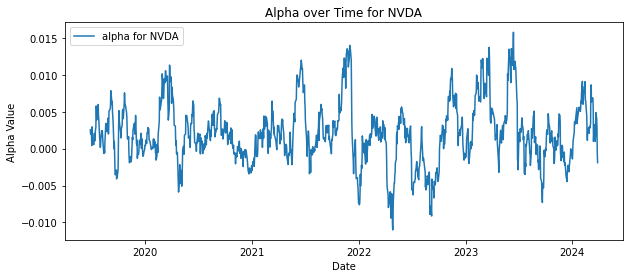

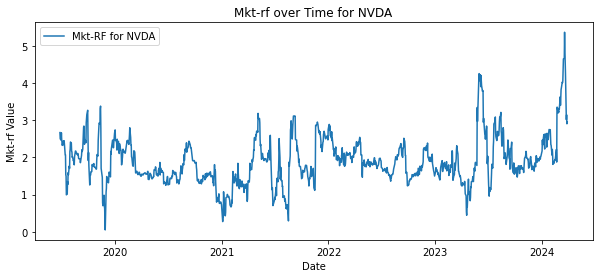

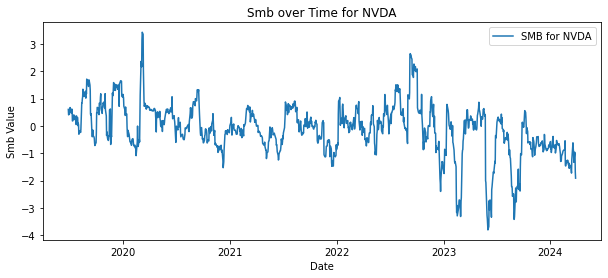

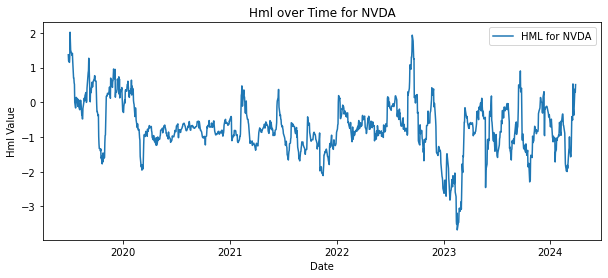

Processing MSFT...


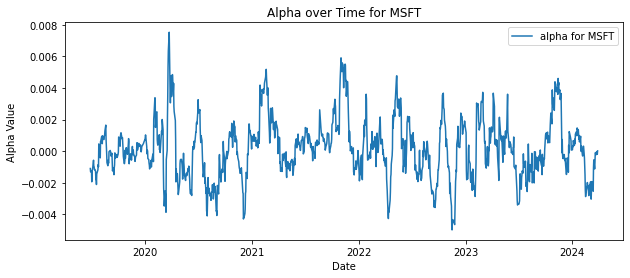

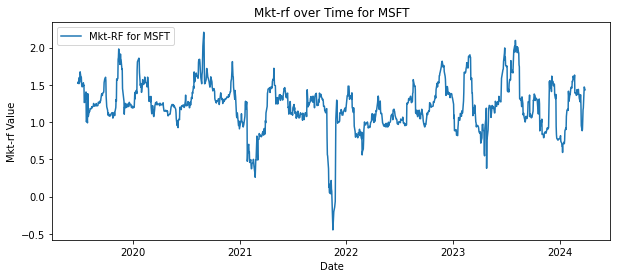

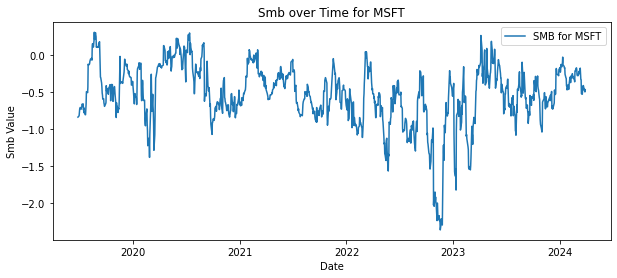

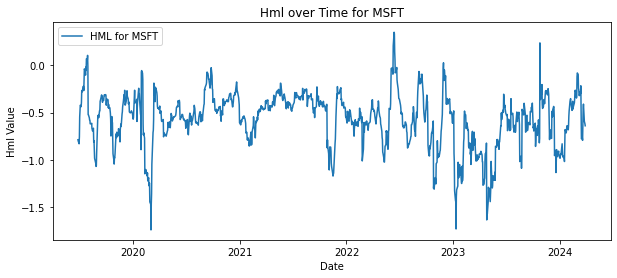

Processing META...


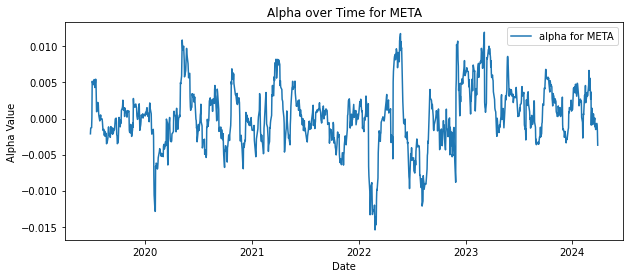

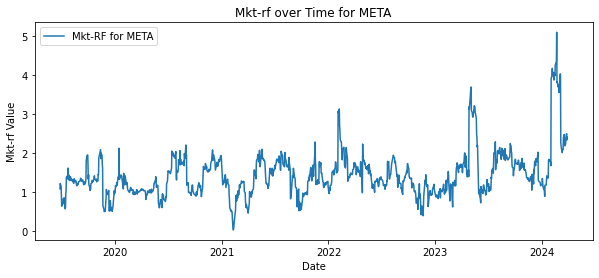

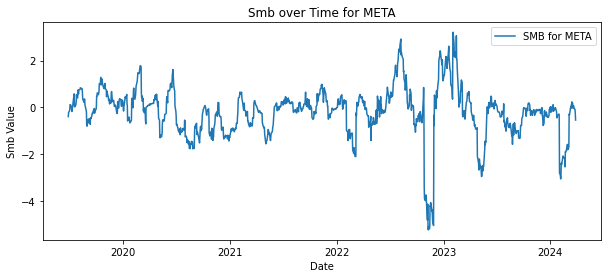

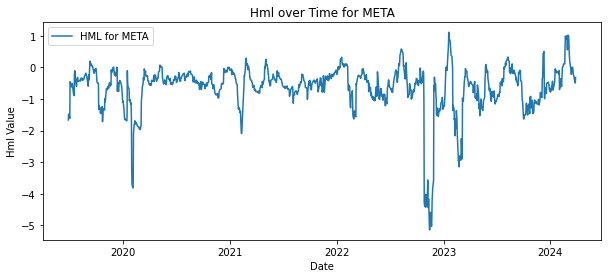

Processing MA...


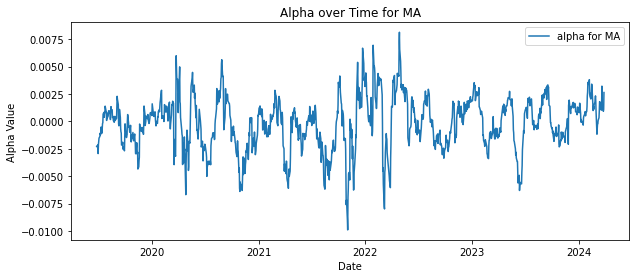

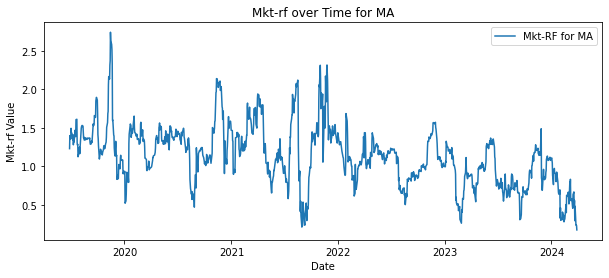

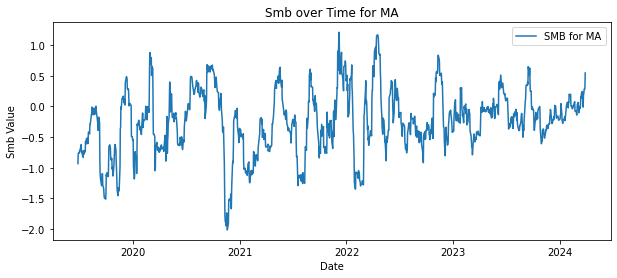

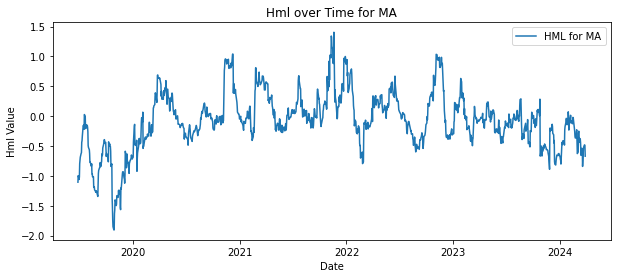

Processing GOOG...


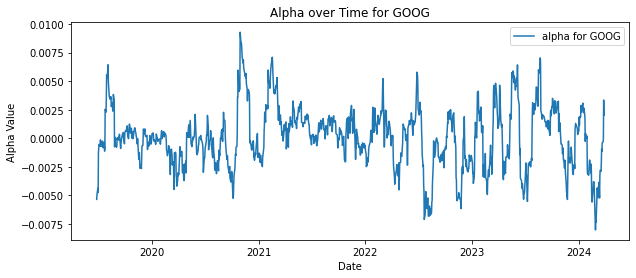

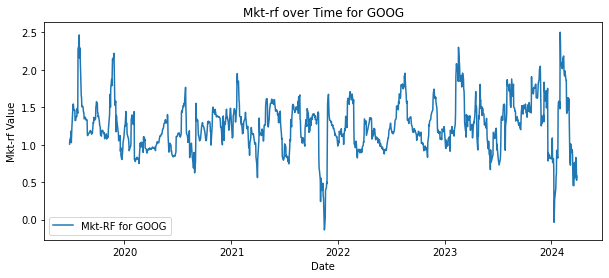

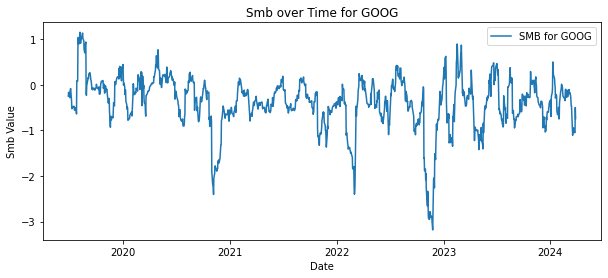

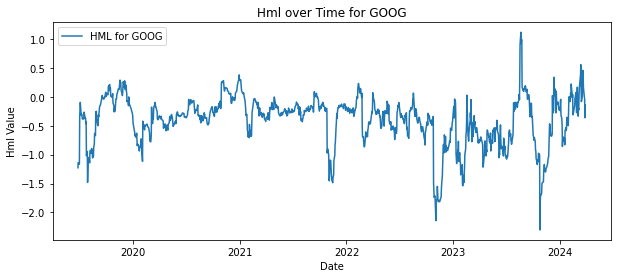

Processing GE...


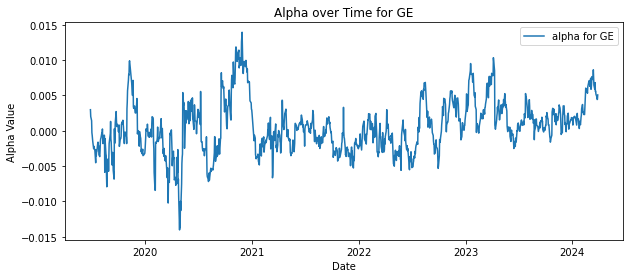

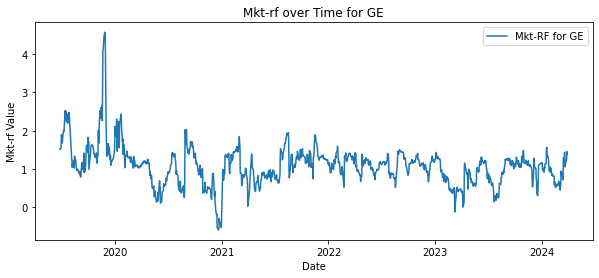

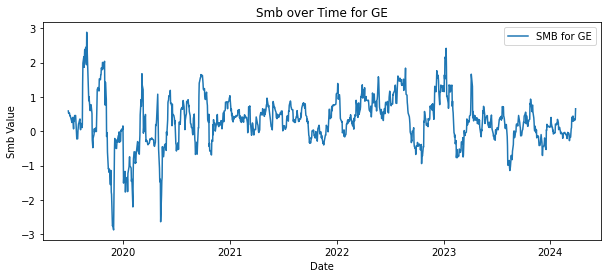

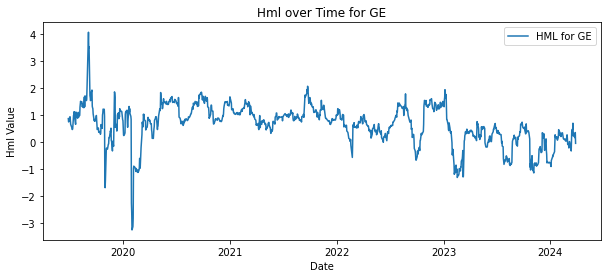

Processing AMZN...


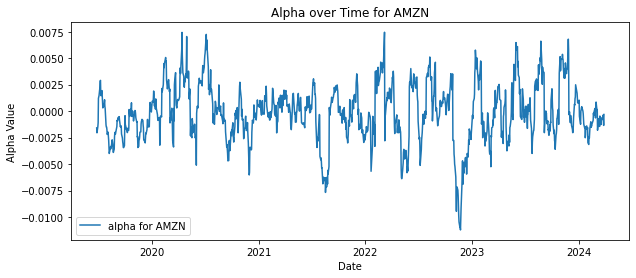

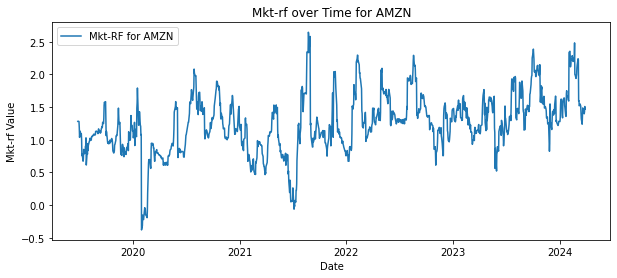

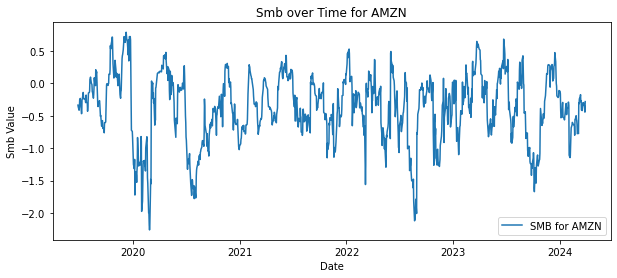

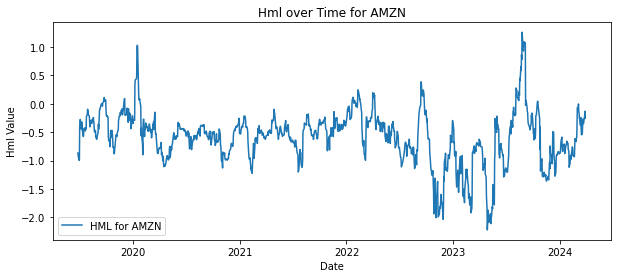

Processing AAPL...


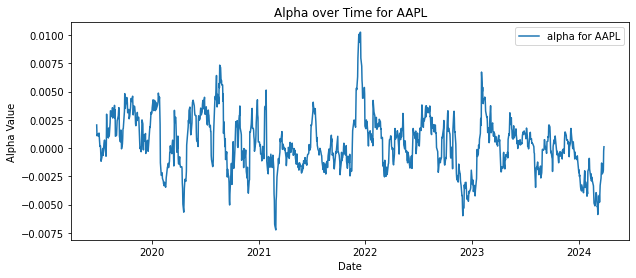

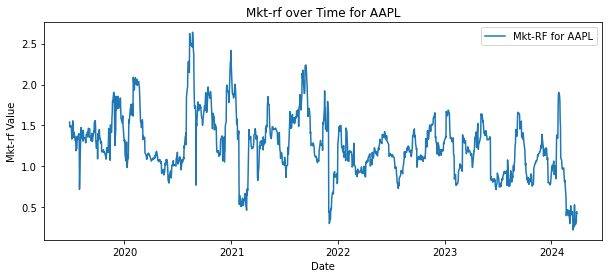

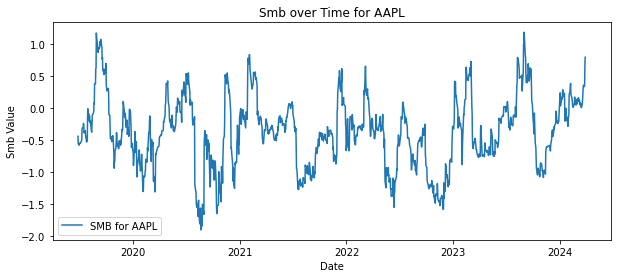

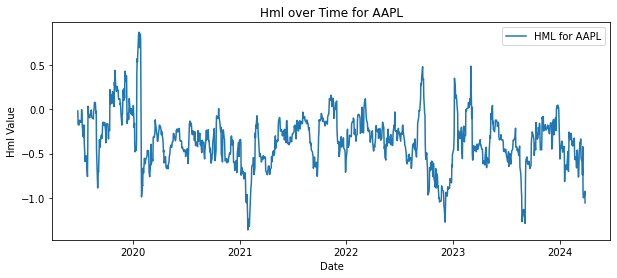

In [30]:
FF_coef_dfs= run_rolling_regression(data=data, stock_list=stock_list, factors=FF_factors, rolling_window_size=rolling_window_size)

# Creating Portfolio of Arbitrage Weight and Security

In [31]:
# Use this as stock data 
stock_data_final

Ticker,Date,AAPL,AMZN,GE,GOOG,MA,META,MSFT,NVDA,TSLA,WMT
0,2019-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-05-29,-0.004769,-0.009388,0.001068,-0.015598,0.000513,-0.011502,-0.009670,-0.020861,0.006147,-0.002929
2,2019-05-30,0.005187,-0.001578,0.010672,0.001335,0.002485,0.004501,0.006323,-0.008764,-0.008638,0.000685
3,2019-05-31,-0.018116,-0.022711,-0.003168,-0.012809,-0.010622,-0.030272,-0.016305,-0.026238,-0.016258,-0.007339
4,2019-06-03,-0.010110,-0.046409,0.009534,-0.061071,-0.036701,-0.075055,-0.031048,-0.012402,-0.033431,0.005126
...,...,...,...,...,...,...,...,...,...,...,...
1214,2024-03-22,0.005310,0.004042,-0.008435,0.020371,-0.014264,0.003584,-0.001467,0.031213,-0.011515,-0.009439
1215,2024-03-25,-0.008300,0.004696,-0.009478,-0.004085,-0.011689,-0.012873,-0.013715,0.007562,0.010537,-0.004929
1216,2024-03-26,-0.006673,-0.007846,0.000346,0.003639,0.001596,-0.014174,-0.002861,-0.025694,0.029195,-0.000991
1217,2024-03-27,0.021213,0.008581,0.037856,0.001582,0.002412,-0.004094,-0.000522,-0.024967,0.012157,0.003471


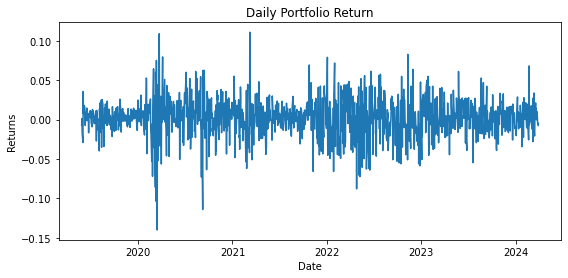

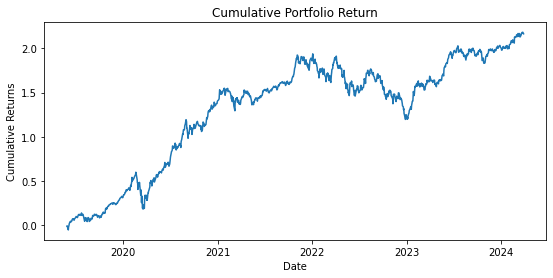

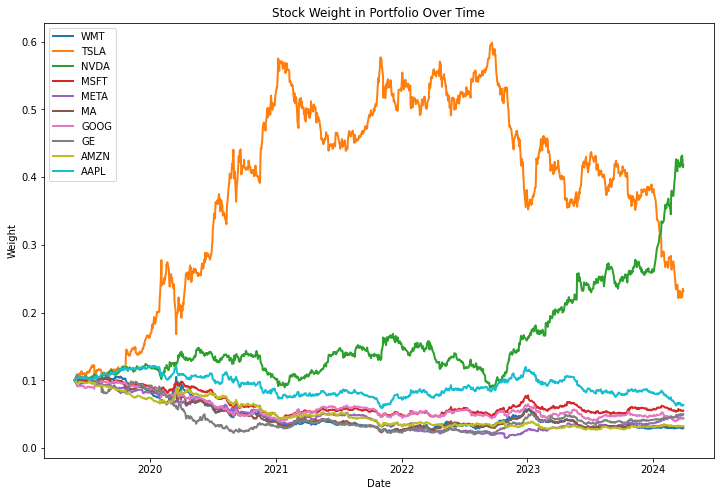

In [32]:
weights = [1/10]*10

port_data, weight_data, port_mean_ret, port_cov_matrix, port_std = generate_portfolio(sdata=stock_data_final,stock_list=stock_list,weights=weights, initial_endow=1000000,start_date=start_date)

# Risk Metrics

### Sharpe Ratio

In [33]:
port_sharpe = get_Sharpe()
# Annualized Sharpe
port_sharpe*np.sqrt(252)

1.4158661268896895

### Sortino Ratio

In [34]:
downside_deviation,sortino = get_Sortino(port_data=port_data)
print(f"Portoflio downside std: {downside_deviation*100:.6f}% | Portfolio Sortino ratio: {sortino:.6f}")

Portoflio downside std: 1.784019% | Portfolio Sortino ratio: 0.095392


### Max Drawdown

Portoflio's MDD started on 2021-11-04 00:00:00 and the MDD took place on 2022-12-27 00:00:00, and resulted in a -57.611% DD.


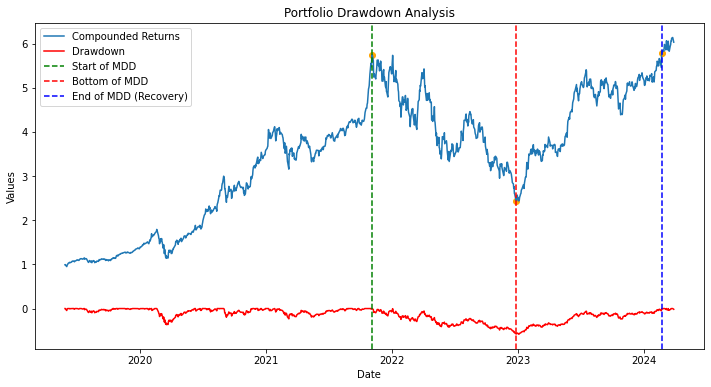

In [35]:
MDD, MDD_start_date, MDD_date, end_date, drawdown, comp_ret= get_MDD(port_data)
print(f"Portoflio's MDD started on {MDD_start_date} and the MDD took place on {MDD_date}, and resulted in a {MDD*100:.3f}% DD.")

plot_drawdown(port_data)

### Calmar Ratio

In [36]:
port_Calmar = get_Calmar(port_data)
port_Calmar

0.0030831993136654257

### VaR

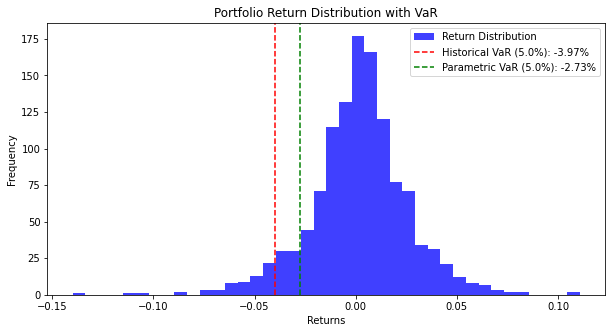

{'Dollar Parametric VaR': 27292.95910809755,
 'Parametric VaR': 0.02729295910809755,
 'Parametric CVaR': 0.4197828641011708,
 'Dollar Historical VaR': -39688.10073299274,
 'Historical VaR': -0.03968810073299274,
 'Historical CVaR': -0.05625597261981456}

In [37]:
VaR_results = get_VaRs(port_data,port_value=1000000)
VaR_results

In [38]:
def port_rolling_regression(port_data, factors, rolling_window_size):
    """
    Run rolling regression for the portfolio returns and factors, and plot coefficients over time using dates on the x-axis.

    Parameters:
        port_data (DataFrame): The data containing 'Portfolio_Return' and factor values, indexed by date.
        factors (list): List of factor column names in the data.
        rolling_window_size (int): Number of observations in the rolling window.
    """
    # Get excess return
    
    port_data['Excess_return'] = port_data['Portfolio_return']-data['RF']
        
    # Dict comprehension to initialize coefficients dictionary
    port_coefs = {factor: [] for factor in ['alpha'] + factors}
    dates = []  # List to store the dates for plotting
    
    
    # Perform rolling regression over the specified window size
    for k in range(len(port_data) - rolling_window_size):
        # Align data using [1:] to remove the first observation 
        y = port_data['Excess_return'][1:].iloc[k:rolling_window_size + k + 1]
        x = add_constant(data[factors].iloc[k:rolling_window_size + k + 1])
        temp_reg = sm.OLS(y, x).fit(cov_type='HC2')

        port_coefs['alpha'].append(temp_reg.params['const'])
        for factor in factors:
            port_coefs[factor].append(temp_reg.params[factor])
        dates.append(port_data.index[rolling_window_size + k])  # Append the last date of the window

    # Creating a DataFrame for the coefficients, indexed by the corresponding dates
    coef_df = pd.DataFrame(port_coefs, index=dates)

    # Plot each coefficient in separate figures
    for coef in port_coefs.keys():
        plt.figure(figsize=(10, 4))
        plt.plot(coef_df.index, coef_df[coef], label=f'{coef} for Portfolio')
        plt.title(f'{coef.capitalize()} over Time for Portfolio')
        plt.xlabel('Date')
        plt.ylabel(f'{coef.capitalize()} Value')
        plt.legend()
        plt.show()

    return coef_df

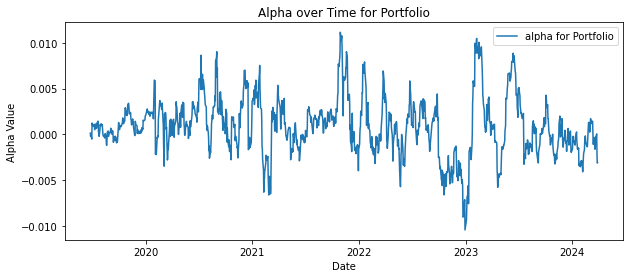

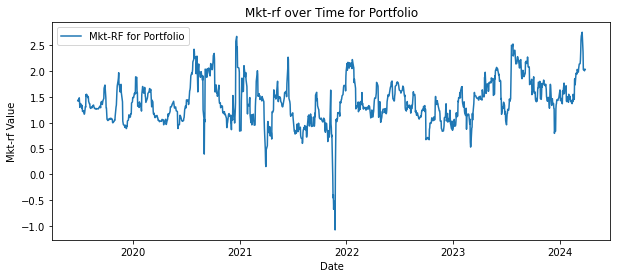

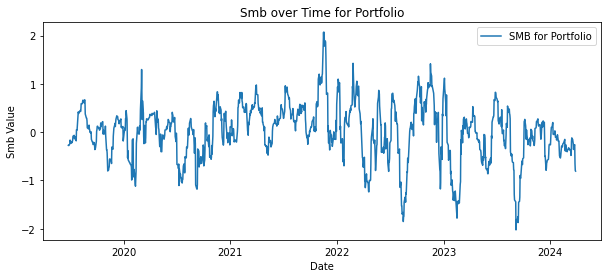

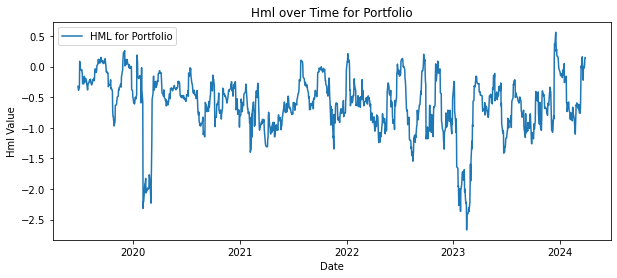

In [39]:
coef_df = port_rolling_regression(port_data, factors= FF_factors, rolling_window_size=rolling_window_size)

In [40]:
coef_df

,alpha,Mkt-RF,SMB,HML
2019-06-26,0.000133,1.428590,-0.272357,-0.321891
2019-06-27,-0.000195,1.444521,-0.277638,-0.350409
2019-06-28,-0.000035,1.426618,-0.276515,-0.386778
2019-07-01,-0.000513,1.484728,-0.243565,-0.335043
2019-07-02,0.001240,1.395690,-0.164869,0.086657
...,...,...,...,...
2024-03-22,-0.000288,2.029477,-0.286184,0.001297
2024-03-25,0.000048,2.018691,-0.259126,-0.020771
2024-03-26,-0.002173,2.007890,-0.654850,0.044389
2024-03-27,-0.003130,2.042125,-0.797535,0.145178


# Risk Decomposition

In [41]:
residuals

,WMT,TSLA,NVDA,MSFT,META,MA,GOOG,GE,AMZN,AAPL
Date,,,,,,,,,,
2019-05-29,-0.000321,0.019545,-0.007554,-0.001206,-0.000726,0.007491,-0.007362,0.005930,0.000228,0.003561
2019-05-30,-0.001747,-0.016512,-0.020247,-0.000618,-0.002801,0.000408,-0.003977,0.014971,-0.009165,-0.000833
2019-05-31,-0.001683,0.002235,-0.006311,-0.002078,-0.014100,0.004760,0.001180,0.012801,-0.009629,-0.003567
2019-06-03,0.009205,-0.020004,0.007048,-0.017513,-0.059741,-0.032086,-0.050276,-0.000100,-0.030003,0.001297
2019-06-04,-0.004490,0.042316,0.027212,0.001494,-0.009553,0.002628,-0.009149,0.021973,-0.002359,0.009599
...,...,...,...,...,...,...,...,...,...,...
2024-03-22,-0.011853,-0.007784,0.027703,-0.005816,0.001574,-0.014365,0.018356,-0.000527,0.000743,0.002392
2024-03-25,-0.004116,0.020505,0.017361,-0.008283,-0.005020,-0.010312,0.000785,-0.013470,0.012879,-0.003549
2024-03-26,0.000067,0.028877,-0.024790,-0.000577,-0.012128,0.004918,0.005821,0.003319,-0.006190,-0.004487


In [42]:
common_factor_risk_pct ,common_factor_variance, specific_variance = factor_risk_decomp(data,B, FF_factors)

Common Factor Variance: 0.000400
Specific Variance: 0.000182
Percentage of Portfolio Variance Due to Common Factor Risk: 0.69%
